In [1]:
%matplotlib inline
import numpy as np
from numpy import linalg as la
#ディガンマ関数のライブラリ
from scipy.special import digamma
from scipy import stats
from scipy.stats import multivariate_normal
import math
import matplotlib.pyplot as plt
import random

In [2]:
def dataset(mu,sigma,pi):
    for i in range(k):
        samplesB = np.random.multivariate_normal(mu[i],sigma[i],int(N*pi[i])).T
        if(i>=1):
            samplesA = np.column_stack((samplesA,samplesB))
        else:
            samplesA = samplesB
    sample = np.c_[samplesA[0],samplesA[1]]
    
    plt.scatter(sample[:,0],sample[:,1],color='g',marker='+',alpha=0.8)
    return sample

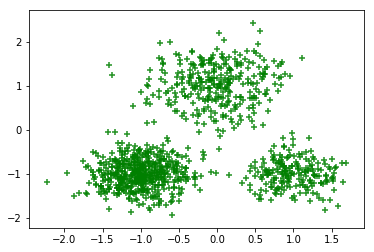

In [3]:
#初期設定
N = 1000 #データ数
#mu = [[-3,-3],[2,2]]
mu = [[0,1],[-1,-1],[1,-1],[3,1]]
sigma = [[[0.2,0.],[0.,0.2]],[[0.1,0.],[0.,0.1]],[[0.1,0.],[0.,0.1]],[[0.2,0.],[0.,0.2]]]
pi=[0.3,0.5,0.2,]
k=3 #データ群の個数
K=8 #分布の個数
D=2 #次元
samples = dataset(mu,sigma,pi)
plt.scatter(samples[:,0],samples[:,1],color='g',marker='+',alpha=0.2)

In [4]:
clus_center = []
for i in range(K):
    clus_center.append([random.uniform(-2,2),random.uniform(-2,2)])
print(clus_center)

[[-0.3510233638964033, 0.15607170769332201], [-0.06597716134630538, -0.4621312681021541], [-0.7350226877864228, -1.8722658498082154], [1.6842062856490596, 0.2531181030722216], [0.15727476162549747, -0.5761336324959236], [0.8805862455138862, 0.6496731227332231], [-1.0917667491097487, 1.2363324458858922], [0.25637466115317187, 0.2614408939017516]]


In [5]:
class KMeans:
    def __init__(self):
        
        #クラスタの色
        self.color = ["r","b","c","m","y","g","k", '#f781bf']
        
        #二値指示変数
        self.r = [1,0]
        
        #クラスタ数
        self.k = K
        
        #データ数
        self.node = 300
        
    def cluster_center(self,mu2):
        
        #クラスター中心の初期値
        x = [mu2[i][0] for i in range(K)]
        y = [mu2[i][1] for i in range(K)]
        self.u = [x,y]
        
    def param_init(self):
        self.count = []
        self.sum = []
        self.t =[]
        self.clus = []
        self.b = []
        
    def figure_plot(self,sample,u,k,clus):
        X=sample[:,0]
        Y=sample[:,1]
        #新しい描画を開始
        plt.figure()
        plt.scatter(sample[:,0],sample[:,1],c=clus,s=20,marker='+',edgecolors='k',alpha=0.4)
        plt.scatter(u[0][0:k],u[1][0:k],c=self.color,s=100,marker="x",edgecolors='k')
        self.distance(sample,u,k)  
        
    def distance(self,sample,u,k):
        #変数の初期化
        self.param_init()
        X=sample[:,0]
        Y=sample[:,1]
        #配列の準備
        for i in range(0,k):
            self.b.append([u[0][i],u[1][i]])
            self.count.append(0)
            self.sum.append([0.0,0.0])
            self.t.append(0)
        self.sum = np.array(self.sum)
        
        for i,j in zip(X,Y):
            distance = []
            a = np.array([i, j])
            
            #各中心と各データの二乗距離
            for i in range(0,k):
                distance.append(np.linalg.norm(self.b[i] - a))
            
            #クラス分け
            self.clus.append(self.color[distance.index(min(distance))])
            self.count[distance.index(min(distance))] += 1
            self.sum[distance.index(min(distance))] += a
        
        #クラスタ中心の更新
        for i in range(0,k):
            self.t[i] = self.sum[i]/self.count[i]
        for i in range(0,2):
            for j in range(0,k):
                self.u[i][j] = self.t[j][i]

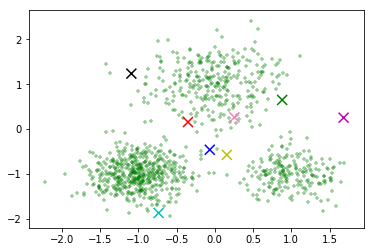

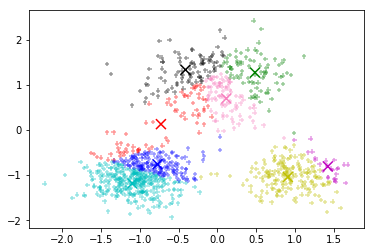

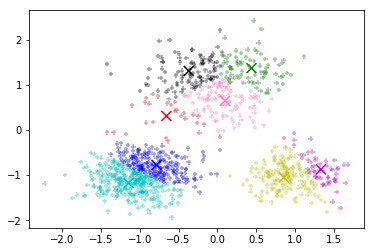

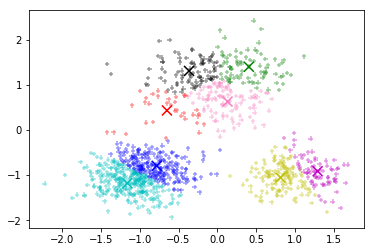

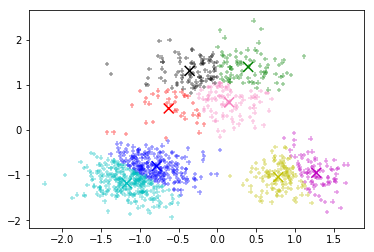

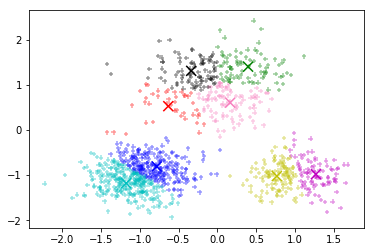

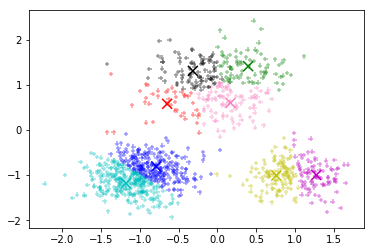

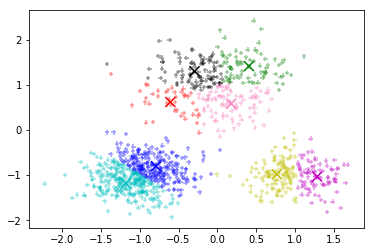

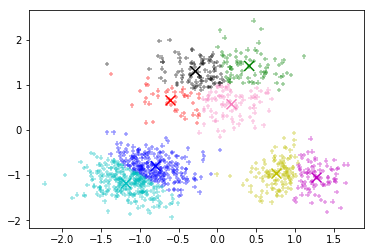

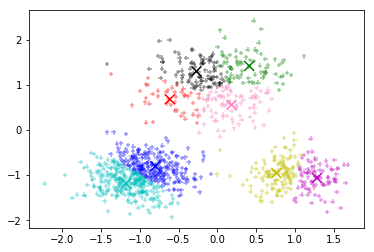

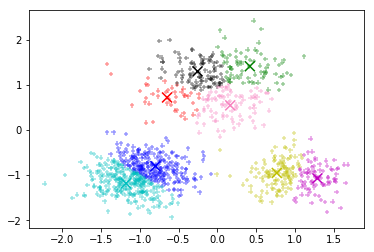

In [6]:
km = KMeans()
km.cluster_center(clus_center)
km.figure_plot(samples,km.u,km.k,km.color[5])
for i in range(10):
    km.figure_plot(samples,km.u,km.k,km.clus)
clus_center=[]
for i in range(K):
    clus_center.append([km.u[0][i],km.u[1][i]])

In [7]:
clus_center

[[-0.65621273796601853, 0.74152214453433063],
 [-0.79828612586899683, -0.80255347269124178],
 [-1.1773228893611305, -1.1823479405148798],
 [1.2921486037342218, -1.0899222251757474],
 [0.77205739247011662, -0.94300242042662685],
 [0.41968988495166532, 1.4009788499172393],
 [-0.24338220447243125, 1.2989117457872237],
 [0.15669824505114924, 0.53222140322414369]]

In [8]:
def make_gauss_model(mu,sigma):
    gauss = []
    for i in range(K):
        gauss.append(multivariate_normal(mean=mu[i],cov=sigma[i]))
        
    return gauss

In [9]:
def draw(gauss):
    plt.figure(figsize=(5, 5))
    # ガウス分布を等高線で描画
    x,y = np.meshgrid(np.linspace(min(samples[:,0]),max(samples[:,0]),1000),np.linspace(min(samples[:,1]),max(samples[:,1]),1000))
    pos = np.dstack((x,y))
    for i in range(K):
        z = gauss[i].pdf(pos)
        plt.contour(x, y, z,colors=clus[i],alpha=0.8)
    #plt.xlim(-5.1, 5.1)
    #plt.ylim(-5.1, 5.1)
    plt.scatter(samples[:,0],samples[:,1],color="g",marker='+',alpha=0.3)

In [10]:
def draw2(gauss,ganma):
    plt.figure(figsize=(5, 5))
    # ガウス分布を等高線で描画
    x,y = np.meshgrid(np.linspace(min(samples[:,0]),max(samples[:,0]),1000),np.linspace(min(samples[:,1]),max(samples[:,1]),1000))
    pos = np.dstack((x,y))
    for i in range(K):
        z = gauss[i].pdf(pos)
        if pi[i] > 0.01: 
            plt.contour(x, y, z,colors=clus[i],alpha=0.8)
    for i in range(N):
        #plt.xlim(min(samples[:,0])+0.1,max(samples[:,0])+0.1)
        #plt.ylim(min(samples[:,1])+0.1,max(samples[:,1])+0.1)
        plt.scatter(samples[i][0],samples[i][1],color="g",marker='+',alpha=0.3)

In [11]:
print(type(clus_center))

<class 'list'>


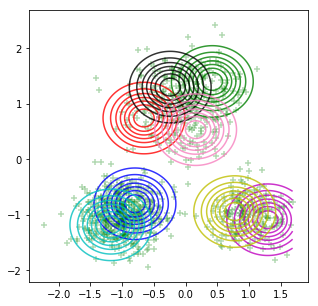

In [12]:
g_sigma = [[[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]],
          [[0.1,0],[0,0.1]]]
pi = [1.0/K for i in range(K)]
clus = ["r","b","c","m","y","g","k", '#f781bf']
gauss = make_gauss_model(clus_center,g_sigma)
draw(gauss)

In [13]:
def ganma_cal():
    ganma = []
    for i in range(N):
        sum_p = 0.0
        p=[]
        for j in range(K):
            sum_p += pi[j]*gauss[j].pdf([samples[i][0],samples[i][1]])
        for j in range(K):
            p.append(pi[j]*gauss[j].pdf([samples[i][0],samples[i][1]])/sum_p)
        ganma.append(p)
    return ganma

In [14]:
def cal(ganma):
    N_k = []
    for k in range(K):
        sum_r = 0.0
        for n in range(N):
             sum_r += ganma[n][k]
        N_k.append(sum_r)
    return N_k

In [15]:
ganma = ganma_cal()
N_k = []
N_k = cal(ganma)
print(N_k)
mu = np.zeros((K,D))
S = np.zeros((K,D,D))

[51.425584699728368, 240.49124072705357, 257.26569271974455, 89.655279932006579, 111.63724307856178, 77.503427646680436, 88.776630911143428, 83.244900285080476]


In [16]:
def cal_3(N_k,ganma):
    #行列の初期化
    #mu = np.zeros((K,D))
    #S = np.zeros((K,D,D))
    for k in range(K):
        sum_r = 0.0
        sum_x = 0.0
        sum_y = 0.0
        for n in range(N):
            sum_r += ganma[n][k]*samples[n]
        mu[k] = sum_r/N_k[k]
        sigma = []
        sigma = [samples[j]-mu[k] for j in range(N)]
        tmp = np.zeros((1,D,D))
        for n in range(N):
            tmp += (ganma[n][k]*sigma[n])*sigma[n][:, np.newaxis]
        tmp2 = tmp/N_k[k]
        S[k] = tmp2
    return mu,S

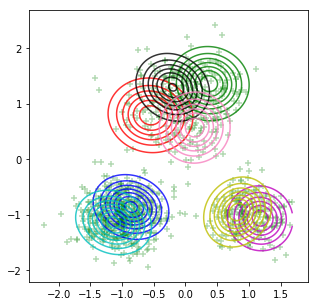

In [17]:
mu,S = cal_3(N_k,ganma)
gauss = make_gauss_model(mu,S)
draw2(gauss,ganma)

In [18]:
def M_step(N_k,mu,S):
    alpha_0 = 0.001
    beta_0 = 0.001
    nu_0 = 1.0
    m_0 = np.zeros((K,D))
    m = np.zeros((K,D))
    W_0 = np.identity(2)
    alpha=[]
    beta=[]
    nu=[]
    W = np.zeros((K,D,D))
    for k in range(K):
        alpha.append(alpha_0 + N_k[k])
        beta.append(beta_0 + N_k[k])
        nu.append(nu_0 + N_k[k])
        m[k] = (beta_0*m_0[k] + N_k[k]*mu[k])/beta[k]
    sigma = []
    sigma = [mu[j]-m_0[j] for j in range(K)]
    for k in range(K):
        tmp = beta_0*N_k[k]*sigma[k]*sigma[k][:, np.newaxis]/(beta_0 + N_k[k])
        tmp2 = la.inv(W_0)+N_k[k]*S[k]+tmp
        W[k] = la.inv(tmp2)
    return alpha,beta,nu,m,W

In [19]:
def E_step(alpha,beta,nu,m,W):
    E_ln_A = []
    E_ln_pi = []
    E_mu_A = []
    r = []
    for k in range(K):
        tmp = sum([digamma((nu[k]+1-i)/2)for i in range(1,D+1)])
        E = tmp +D*math.log(2)+math.log(la.norm(W[k]))
        E_ln_A.append(E)
        
        E = digamma(alpha[k])-digamma(sum(alpha))
        E_ln_pi.append(E)
    for n in range(N):
        tmp = [(D/beta[k])+nu[k]*np.dot((samples[n] - m[k]),np.dot(W[k],(samples[n] - m[k]).T)) for k in range(K)]
        E_mu_A.append(tmp)
    for n in range(N):
        tmp = [np.exp(np.array(E_ln_pi[k]) + np.array(E_ln_A[k])/2 - D*math.log(2*math.pi)/2-np.array(E_mu_A[n][k])/2) for k in range(K)]
        for k in range(K):
            if tmp[k] < 1e-10:
                tmp[k] = 1e-10
        tmp2 = np.array(tmp)/sum(tmp)
        
        r.append(tmp2)
    return E_ln_A,E_ln_pi,E_mu_A,r

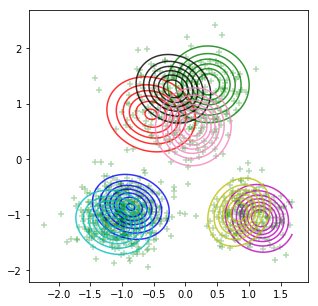

count:0
[ 0.05095247  0.24011054  0.25689324  0.08920063  0.11119332  0.07704287
  0.08832155  0.08278713]


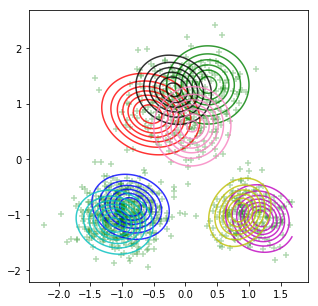

count:1
[ 0.04604658  0.23917828  0.25966462  0.08467473  0.11450425  0.07667224
  0.09252763  0.08323351]


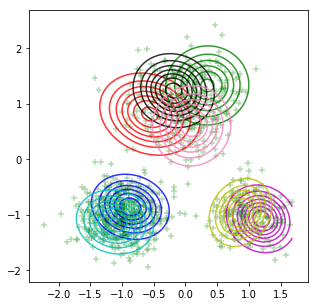

count:2
[ 0.04134106  0.23701596  0.26218722  0.0796204   0.11923778  0.07666357
  0.09643629  0.08399963]


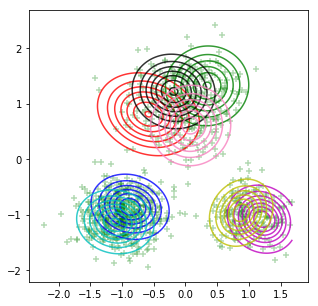

count:3
[ 0.03583197  0.23436908  0.26491046  0.07365304  0.12509626  0.07635108
  0.10100841  0.08528179]


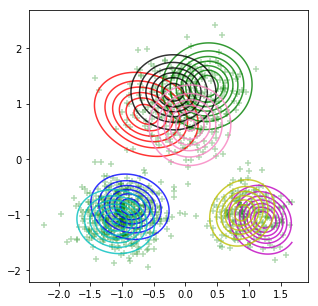

count:4
[ 0.02930476  0.23106618  0.26821876  0.06628216  0.13241986  0.07530747
  0.10691799  0.08698518]


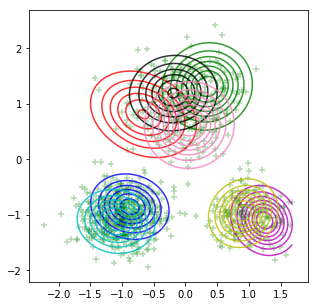

count:5
[ 0.02184306  0.22673554  0.27252963  0.05709769  0.14158482  0.07299289
  0.11489902  0.08882026]


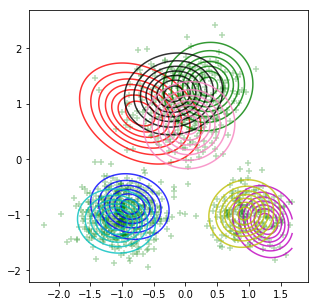

count:6
[ 0.01393934  0.22088661  0.27833977  0.04583093  0.1528514   0.06866622
  0.12581651  0.09017337]


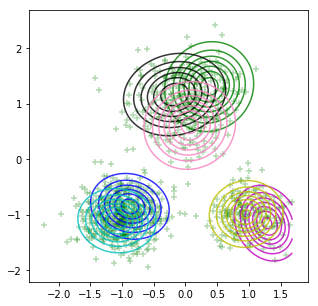

count:7
[ 0.00669641  0.21286835  0.28628809  0.03264252  0.16605926  0.06140628
  0.14061245  0.08993439]


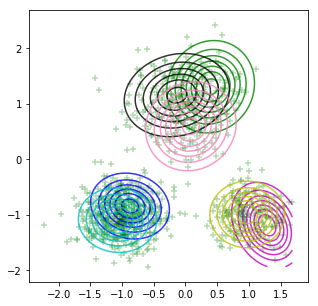

count:8
[ 0.00167331  0.20181207  0.29722495  0.01886916  0.17987802  0.05036055
  0.16017038  0.08653821]


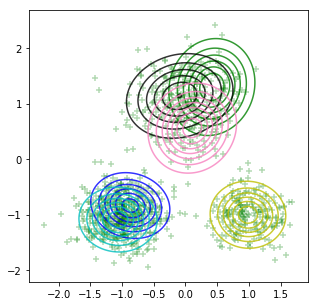

count:9
[  1.19198869e-06   1.86604315e-01   3.12268196e-01   7.55229707e-03
   1.91276846e-01   3.54942373e-02   1.85201498e-01   7.84524683e-02]


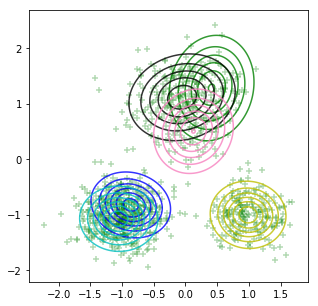

count:10
[ 0.          0.16592724  0.33275213  0.00131622  0.19764491  0.01906886
  0.21559437  0.06472743]


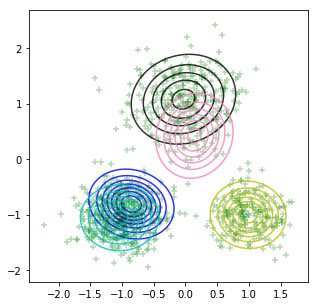

count:11
[  0.00000000e+00   1.38591508e-01   3.59923318e-01   7.96108969e-11
   1.99470376e-01   6.26302915e-03   2.47327993e-01   4.58667988e-02]


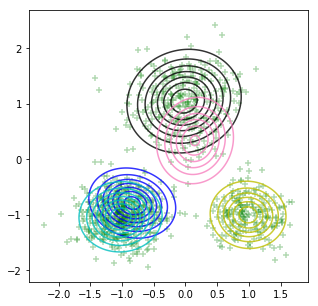

count:12
[ 0.          0.10439734  0.39396902  0.          0.19958098  0.00061313
  0.27363742  0.02535884]


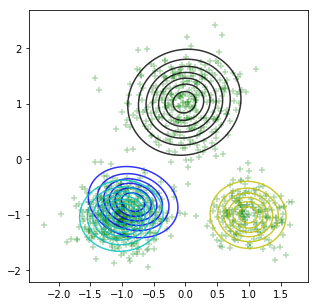

count:13
[  0.00000000e+00   6.61253622e-02   4.32064063e-01   0.00000000e+00
   1.99529635e-01   2.22124930e-43   2.91238152e-01   9.03442517e-03]


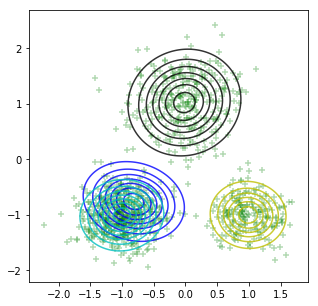

count:14
[ 0.          0.03146474  0.46650643  0.          0.19933712  0.
  0.29948603  0.00123525]


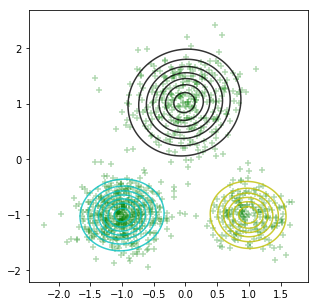

count:15
[  0.00000000e+00   9.52566516e-03   4.88371920e-01   0.00000000e+00
   1.99163381e-01   0.00000000e+00   3.01389441e-01   1.58546065e-12]


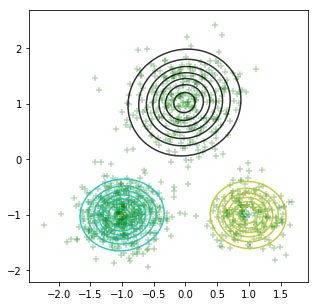

count:16
[ 0.          0.00118662  0.49681247  0.          0.19904606  0.
  0.30148351  0.        ]


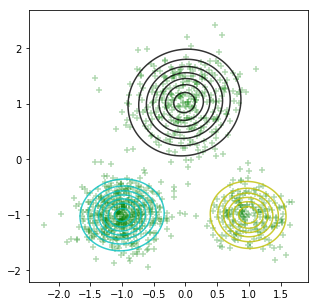

count:17
[  0.00000000e+00   9.08529270e-14   4.98489361e-01   0.00000000e+00
   1.99015842e-01   0.00000000e+00   3.01446453e-01   0.00000000e+00]


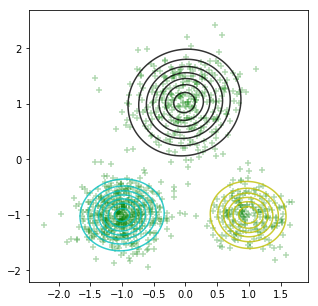

count:18
[ 0.          0.          0.49859121  0.          0.19900189  0.          0.3014018
  0.        ]


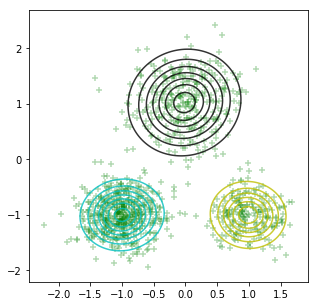

count:19
[ 0.          0.          0.49860815  0.          0.19899974  0.          0.301387
  0.        ]


In [20]:
for i in range(20):
    alpha,beta,nu,m,W = M_step(N_k,mu,S)
    E_ln_A,E_ln_pi,E_mu_A,ganma = E_step(alpha,beta,nu,m,W)
    pi = np.exp(E_ln_pi)
    N_k = cal(ganma)
    mu,S = cal_3(N_k,ganma)
    gauss = make_gauss_model(mu,S)
    draw2(gauss,ganma)
    #['r','g','b','y',"c", "m"]
    plt.show()
    print("count:{}".format(i))
    print(pi)